# ASR Lab 2 - Computing HMM probabilities

To begin with, we'll use the code you wrote in Lab 1 to generate a Word WFST for the word "*peppers*", using `generate_word_wfst('peppers')`.  By viewing this as an HMM, you'll be able to sample possible paths through the model and also generate the likelihood of an observation sequence $(x_1, \dotsc, x_T)$.

We have also created [technical documentation](https://openfst-python-documentation.readthedocs.io/en/latest/lab2.html) to accompany this lab.

In this lab we only compute likelihoods along single (random) paths.  In Labs 3 and 4 we'll build on this to implement the basics of the Viterbi algorithm, which can later be used for word recognition.

First, copy your code from Lab 1 into the space below.  You can use the official solutions if you like.
If you want to extract the code-only parts of your previous notebook, on the terminal command line you can type:

```bash
jupyter nbconvert --to python <notebook-name.ipynb>
```

where <notebook-name.ipynb> indicates the path of the notebook file.

In [2]:
import openfst_python as fst

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

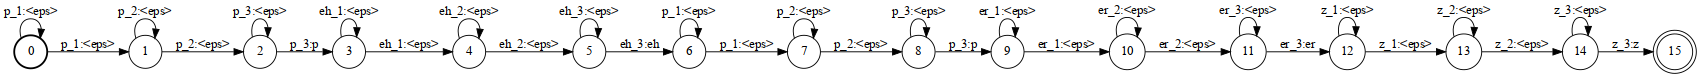

In [3]:
def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, None, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, out_label, None, next_state))    
       
        current_state = next_state
    return current_state

f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_phone_wfst(f, start, 'p', 3)

f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """

    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        # your code here
        
        current_state = generate_phone_wfst(f, current_state, phone, n)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f

f = fst.Fst()
start = f.add_state()
f.set_start(start)

generate_word_wfst(f, start, 'peppers', 3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

Now that the WFST has been constructed, we can traverse over the states and arcs.  This example shows how you can do this:

In [4]:
for state in f.states():
    
    # iterate over all arcs leaving this state    
    for arc in f.arcs(state):
         print(state, arc.ilabel, arc.olabel, arc.weight, arc.nextstate)

0 19 0 0 0
0 19 0 0 1
1 20 0 0 1
1 20 0 0 2
2 21 0 0 2
2 21 7 0 3
3 22 0 0 3
3 22 0 0 4
4 23 0 0 4
4 23 0 0 5
5 24 0 0 5
5 24 8 0 6
6 19 0 0 6
6 19 0 0 7
7 20 0 0 7
7 20 0 0 8
8 21 0 0 8
8 21 7 0 9
9 25 0 0 9
9 25 0 0 10
10 26 0 0 10
10 26 0 0 11
11 27 0 0 11
11 27 9 0 12
12 28 0 0 12
12 28 0 0 13
13 29 0 0 13
13 29 0 0 14
14 30 0 0 14
14 30 10 0 15


Alternatively, we could begin at the start state, and traverse in a depth-first manner.  **Warning**: the code below specifically handles self-loops, but won't work if your WFST has larger cycles in it!

In [5]:
def traverse_arcs(state):
    """Traverse every arc leaving a particular state
    """
    for arc in f.arcs(state):
        print(state, arc.ilabel, arc.olabel, arc.weight, arc.nextstate)
        
        if arc.nextstate != state:   # don't follow the self-loops or we'll get stuck forever!
            traverse_arcs(arc.nextstate)

s = f.start()
traverse_arcs(s)

0 19 0 0 0
0 19 0 0 1
1 20 0 0 1
1 20 0 0 2
2 21 0 0 2
2 21 7 0 3
3 22 0 0 3
3 22 0 0 4
4 23 0 0 4
4 23 0 0 5
5 24 0 0 5
5 24 8 0 6
6 19 0 0 6
6 19 0 0 7
7 20 0 0 7
7 20 0 0 8
8 21 0 0 8
8 21 7 0 9
9 25 0 0 9
9 25 0 0 10
10 26 0 0 10
10 26 0 0 11
11 27 0 0 11
11 27 9 0 12
12 28 0 0 12
12 28 0 0 13
13 29 0 0 13
13 29 0 0 14
14 30 0 0 14
14 30 10 0 15


For a more readable table, you could find the indexes of the input and output labels in your symbol tables and print the string instead.

## Exercises

1. Write code to randomly generate (sample) a path through your word HMM for "*peppers*".  You should output the sequence of input and output labels along the path.  To sample from a list of arcs, you can use code like

```python
import random

arc_list = list(f.arcs(state))
sampled_arc = random.choice(arc_list)
```

  Notice that if you repeat your random sampling by running the code multiple times, you'll get paths of different lengths due to the self-loops


In [6]:
import random

def sample_random_path(f):
    '''Given an FST, randomly sample a path through it.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
        '''
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'): # the .final method returns the probability of a state being final
                                                             # it's infinite when the state is NOT final
        arc_list = list(f.arcs(curr_state))
        sampled_arc = random.choice(arc_list)
        ilabel = state_table.find(sampled_arc.ilabel) # search the index in the table, get the string
        input_label_seq.append(ilabel)
        
        olabel = phone_table.find(sampled_arc.olabel)
        output_label_seq.append(olabel)
        
        curr_state = sampled_arc.nextstate

        
    return input_label_seq, output_label_seq



In [7]:
input_label_seq, output_label_seq = sample_random_path(f)
print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))

p_1 <eps>
p_2 <eps>
p_3 p
eh_1 <eps>
eh_1 <eps>
eh_2 <eps>
eh_2 <eps>
eh_2 <eps>
eh_3 eh
p_1 <eps>
p_1 <eps>
p_2 <eps>
p_3 p
er_1 <eps>
er_1 <eps>
er_2 <eps>
er_3 er
z_1 <eps>
z_2 <eps>
z_2 <eps>
z_3 z


2. Now it's time to add probabilities to your WFST.  As mentioned at the end of Lab 1, probabilities in WFSTs are traditionally expressed in negative log format, that is, the weight $w$ on an arc transitioning between states $i$ and $j$ is given by $w=-\log a_{ij}$, where $a_{ij}$ is the HMM transition probability.  Remember that you can add weights using the third argument to `fst.Arc()`.

  You should now modify your code above to add weights to your word and phone recognition WFSTs from Lab 1, corresponding to transition probabilities.  Assume that the probability of a self-loop is $0.1$, and that when transitioning *between* separate multiple sets of phones (or words), the probabilities are uniform over all transitions.

  Remember to set your fst to use log probabilities and use log weights:

```python
import math
f = fst.Fst('log')

s1 = f.add_state()
s2 = f.add_state()
weight = fst.Weight('log', -math.log(0.1))
f.add_arc(s1, fst.Arc(0, 0, weight, s2))
```

In [8]:
import math

def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('log', -math.log(0.1))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(0.9)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state

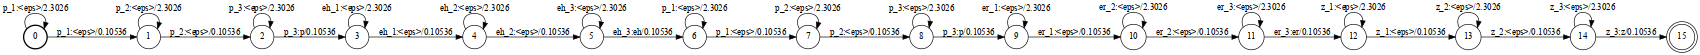

In [9]:
def generate_word_wfst(word):
    """ Generate a WFST for any word in the lexicon, composed of 3-state phone WFSTs.
        This will currently output word labels.  
        Exercise: could you modify this function and the one above to output a single phone label instead?
    
    Args:
        word (str): the word to generate
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create the start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        
        current_state = generate_phone_wfst(f, current_state, phone, 3)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f
  
# example
f = generate_word_wfst('peppers')
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)


# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

The solution is in the modified code generating the fst at the beginning of the notebook.

3. Modify your answer to exercise 1 to sample a path through the word HMM *and* also compute the negative log probability of the path.  This gives you $-\log p(Q)$ in the lecture notation.  (Recall that $\log ab = \log a + \log b$)

  **Note**: Internally OpenFst stores weights in a special object that you will need to convert to a float, using the `float()` function, before adding your negative log probabilities.


In [16]:
def sample_random_path_prob(f):
    '''Given an FST, randomly sample a path through it and compute the negative log probability.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
            neg_log_prob (float): negative log probability of the sampled path
        '''
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []
    neg_log_prob = 0.0 # log(1) = 0

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'): # the .final method returns the probability of a state being final
                                                             # it's infinite when the state is NOT final
        arc_list = list(f.arcs(curr_state))
        sampled_arc = random.choice(arc_list)
        ilabel = state_table.find(sampled_arc.ilabel) # search the index in the table, get the string
        input_label_seq.append(ilabel)
        
        olabel = phone_table.find(sampled_arc.olabel)
        output_label_seq.append(olabel)
        
        curr_state = sampled_arc.nextstate
        
        # Addition:
        neg_log_prob += float(sampled_arc.weight) # transition probability
        
    return input_label_seq, output_label_seq, neg_log_prob

input_label_seq, output_label_seq, neg_log_prob = sample_random_path_prob(f)
print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))
print(neg_log_prob)

p_1 <eps>
p_2 <eps>
p_2 <eps>
p_3 <eps>
p_3 <eps>
p_3 p
eh_1 <eps>
eh_1 <eps>
eh_1 <eps>
eh_1 <eps>
eh_2 <eps>
eh_3 eh
p_1 <eps>
p_2 <eps>
p_3 <eps>
p_3 <eps>
p_3 p
er_1 <eps>
er_1 <eps>
er_2 <eps>
er_2 <eps>
er_3 <eps>
er_3 <eps>
er_3 <eps>
er_3 <eps>
er_3 er
z_1 <eps>
z_2 <eps>
z_2 <eps>
z_2 <eps>
z_2 <eps>
z_2 <eps>
z_2 <eps>
z_2 <eps>
z_3 <eps>
z_3 <eps>
z_3 z
52.23728036500003


4. You are now given a set of observations, ($x_1, \dotsc, x_t, \dotsc$).  Can you use your WFST for the word "*peppers*" to compute $p(X,Q)$ for a randomly sampled path $Q$ through the HMM?  For now, we won't use real samples $x_t$, and will instead assume that you already have a function `observation_probability(state, t)` that computes $b_j(t) = p(x_t|q_t=j)$, provided here:

In [11]:
def observation_probability(hmm_label, t):
    """ Computes b_j(t) where j is the current state
    
    This is just a dummy version!  In later labs we'll generate 
    probabilities for real speech frames.
    
    You don't need to look at this function in detail.
    
    Args: hmm_label (str): the HMM state label, j.  We'll use string form: "p_1", "p_2", "eh_1" etc  
          t (int) : current time step, starting at 1
          
    Returns: 
          p (float): the observation probability p(x_t | q_t = hmm_label)
    """
    
    p = {} # dictionary of probabilities
    
    assert(t>0)
    
    # this is just a simulation!
    if t < 4:
        p = {'p_1': 1.0, 'p_2':1.0, 'p_3': 1.0, 'eh_1':0.2}
    elif t < 9:
        p = {'p_3': 0.5, 'eh_1':1.0, 'eh_2': 1.0, 'eh_3': 1.0}
    elif t < 13:
        p = {'eh_3': 1.0, 'p_1': 1.0, 'p_2': 1.0, 'p_3':1.0, 'er_1':0.5}
    elif t < 18:
        p = {'p_3': 1.0, 'er_1': 1.0, 'er_2': 1.0, 'er_3':0.7}
    elif t < 25:
        p = {'er_3': 1.0, 'z_1': 1.0, 'z_2': 1.0, 'z_3':1.0}
    else:
        p = {'z_2': 0.5, 'z_3': 1.0}
        
    for label in ['p_1', 'p_2', 'p_3', 'eh_1', 'eh_2', 'eh_3', 'er_1', 'er_2', 'er_3', 'z_1', 'z_2', 'z_3']:        
        if label not in p:
            p[label] = 0.01  # give all other states a small probability to avoid zero probability
            
    # normalise the probabilities:
    scale = sum(p.values())
    for k in p:
        p[k] = p[k]/scale
        
    return p[hmm_label]
    

Enter your code below.  You might want to convert the observation probabilities into negative log probabilities.


In [15]:
def sample_random_path_obs_prob(f):
    '''Given an FST and observation probabilities, randomly sample a path
        through it and compute the negative log probability.
    
        Args:
            f (fst.Fst()): an FST
        
        Returns:
            input_label_seq (list(str)): the list of input labels from the arcs that were sampled
            output_label_seq (list(str)): the list of output labels from the arcs that were sampled
            neg_log_prob (float): negative log probability of the sampled path
        '''
    
    # Addition:
    t = 1
    curr_state = f.start() # start from beginning
    weight_type = f.weight_type() # type of weights used in the fst
    input_label_seq = []
    output_label_seq = []
    neg_log_prob = 0.0 # log(1) = 0

    while f.final(curr_state) == fst.Weight(weight_type, 'inf'): # the .final method returns the probability of a state being final
                                                             # it's infinite when the state is NOT final
        arc_list = list(f.arcs(curr_state))
        sampled_arc = random.choice(arc_list) 
        ilabel = state_table.find(sampled_arc.ilabel) # search the index in the table, get the string
        input_label_seq.append(ilabel)
        
        olabel = phone_table.find(sampled_arc.olabel)
        output_label_seq.append(olabel)
        
        curr_state = sampled_arc.nextstate
        
        neg_log_prob += float(sampled_arc.weight) # transition probability
        
        # Addition:
        neg_log_prob -= math.log(observation_probability(ilabel, t)) # emission probability
        t += 1 # going to the next step in the sequence
        
    return input_label_seq, output_label_seq, neg_log_prob

input_label_seq, output_label_seq, neg_log_prob = sample_random_path_obs_prob(f)
print('\n'.join(['{} {}'.format(input_label_seq[i], output_label_seq[i]) for i in range(len(input_label_seq))]))
print(neg_log_prob)

p_1 <eps>
p_2 <eps>
p_3 <eps>
p_3 <eps>
p_3 <eps>
p_3 <eps>
p_3 p
eh_1 <eps>
eh_1 <eps>
eh_1 <eps>
eh_2 <eps>
eh_2 <eps>
eh_2 <eps>
eh_3 eh
p_1 <eps>
p_2 <eps>
p_2 <eps>
p_2 <eps>
p_2 <eps>
p_2 <eps>
p_3 <eps>
p_3 p
er_1 <eps>
er_1 <eps>
er_1 <eps>
er_2 <eps>
er_3 er
z_1 <eps>
z_2 <eps>
z_2 <eps>
z_3 z
170.48377790878732


You might have noticed that the dummy observation probability function above effectively allows the observation sequence $x_t$ to be arbitrarily long.  This is simply to allow it to match the length of your sampled path $Q$.  In real use, the observation sequence will have a fixed length $T$, and any matching path through the HMM will have to have the same length.  We'll explore this more when writing the Viterbi decoder in the next lab.

## If you have more time

You might like to start thinking about how to implement the Viterbi algorithm over HMMs in WFST form.  Try working with the "*peppers*" example above.  You'll need to write functions to compute and store the probabilities $V_j(t)$, giving the probability up to time step $t$ of the observation sequence $(x_1, \dotsc, x_t)$ along the most likely path $(q_1, \dotsc, q_t)$.